In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Carregamento dos Dados
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    print("Arquivos 'train.csv' e 'test.csv' carregados com sucesso!")
    print(f"Dataset de treino possui {df_train.shape[0]} linhas e {df_train.shape[1]} colunas.")
    print(f"Dataset de teste possui {df_test.shape[0]} linhas e {df_test.shape[1]} colunas.")
except FileNotFoundError:
    print("ERRO: Arquivos 'train.csv' ou 'test.csv' não encontrados.")
    print("Por favor, certifique-se de que os arquivos estão no mesmo diretório do seu notebook.")
    # Crie DataFrames vazios para evitar que as próximas células quebrem
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()

Arquivos 'train.csv' e 'test.csv' carregados com sucesso!
Dataset de treino possui 28992 linhas e 526 colunas.
Dataset de teste possui 19328 linhas e 525 colunas.


In [2]:

if not df_train.empty:
    # Define as colunas de features e a coluna alvo
    features = [col for col in df_train.columns if col.startswith('f')]
    target = 'target'

    # Separa as features (X) e o alvo (y)
    X = df_train[features]
    y_raw = df_train[target]

    # Codifica a variável alvo: 'attack' -> 1, 'normal' -> 0
    le = LabelEncoder()
    y = le.fit_transform(y_raw)

    # Garante que 'attack' seja 1
    if le.classes_[0] == 'attack':
        y = 1 - y
        print("Mapeamento da classe alvo: 'attack' -> 1, 'normal' -> 0")
    else:
        print("Mapeamento da classe alvo: 'attack' -> 1, 'normal' -> 0")

    # Divide os dados em treino e validação (80% treino, 20% validação)
    # Usam stratify=y para manter a proporção das classes na divisão
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

    print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_val)} de validação.")

Mapeamento da classe alvo: 'attack' -> 1, 'normal' -> 0
Dados divididos em 23193 amostras de treino e 5799 de validação.


In [3]:

if not df_train.empty:
    # Dicionário com os modelos que vamos testar
    models = {
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        "LightGBM": lgb.LGBMClassifier(random_state=42, n_jobs=-1)
    }

    results = {}
    best_accuracy = 0
    best_model_name = ""
    best_model_instance = None

    # Itera sobre os modelos, treina e avalia cada um
    for name, model in models.items():
        print(f"--- Treinando {name} ---")
        model.fit(X_train, y_train)

        # Faz previsões no conjunto de validação
        preds = model.predict(X_val)

        # Calcula a acurácia
        accuracy = accuracy_score(y_val, preds)
        results[name] = accuracy
        print(f"Acurácia de Validação: {accuracy:.4f}\n")

        # Guarda o melhor modelo encontrado até agora
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_name = name
            best_model_instance = model

    print(f"--- Resultados Finais da Validação ---")
    for name, acc in results.items():
        print(f"Modelo: {name:<15} | Acurácia: {acc:.4f}")
    
    print(f"\nO melhor modelo foi: {best_model_name} com acurácia de {best_accuracy:.4f}")

--- Treinando RandomForest ---
Acurácia de Validação: 0.9200

--- Treinando ExtraTrees ---
Acurácia de Validação: 0.9200

--- Treinando LightGBM ---
[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086
Acurácia de Validação: 0.9196

--- Resultados Finais da Validação ---
Modelo: RandomForest    | Acurácia: 0.9200
Modelo: ExtraTrees      | Acurácia: 0.9200
Modelo: LightGBM        | Acurácia: 0.9196

O melhor modelo foi: RandomForest com acurácia de 0.9200


Gerando curva de aprendizagem para o modelo: RandomForest...


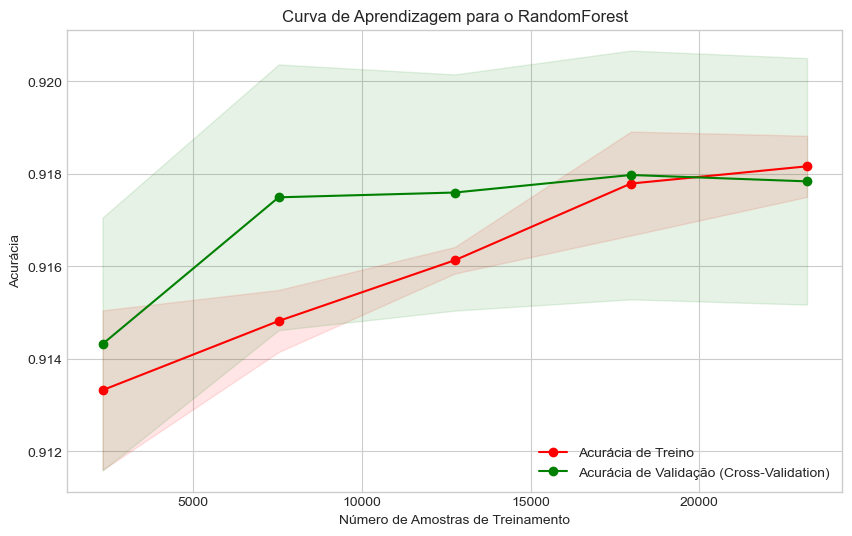

In [4]:
# %%
if not df_train.empty and best_model_instance:
    print(f"Gerando curva de aprendizagem para o modelo: {best_model_name}...")
    
    # Gera os dados para a curva de aprendizagem
    # A função usa validação cruzada para gerar os pontos da curva
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=best_model_instance,
        X=X, # Usa os dados completos para ter uma curva mais representativa
        y=y,
        cv=5, # Número de folds da validação cruzada
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), # Usa 5 pontos, de 10% a 100% dos dados
        scoring='accuracy'
    )

    # Calcula as médias e desvios padrão para plotagem
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plota o gráfico
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Acurácia de Treino")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Acurácia de Validação (Cross-Validation)")
    
    # Adiciona as áreas de desvio padrão
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.title(f'Curva de Aprendizagem para o {best_model_name}')
    plt.xlabel('Número de Amostras de Treinamento')
    plt.ylabel('Acurácia')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [5]:

if not df_train.empty and best_model_instance:
    print(f"Treinando o melhor modelo ({best_model_name}) com todos os dados de treino...")
    
    final_model = best_model_instance
    final_model.fit(X, y) 
    
    print("Modelo final treinado!")

    # Prepara os dados de teste
    X_test = df_test[features]

    # Faz as previsões finais
    print("Fazendo previsões no conjunto de teste...")
    final_predictions_encoded = final_model.predict(X_test)
    
    # Decodifica as previsões de volta para 'attack'/'normal'
    final_predictions = le.inverse_transform(final_predictions_encoded)
    
    # Cria o DataFrame para submissão
    submission_df = pd.DataFrame({'id': df_test['id'], 'target': final_predictions})
    
    # Salva o arquivo de submissão
    submission_df.to_csv('submission.csv', index=False)
    
    print("\nArquivo 'submission.csv' gerado com sucesso!")
    print("Amostra do arquivo de submissão:")
    print(submission_df.head())

Treinando o melhor modelo (RandomForest) com todos os dados de treino...
Modelo final treinado!
Fazendo previsões no conjunto de teste...

Arquivo 'submission.csv' gerado com sucesso!
Amostra do arquivo de submissão:
      id  target
0  24998  attack
1  12486  attack
2   5285  attack
3   5534  attack
4  29985  normal


--- Métricas de Desempenho do Melhor Modelo (RandomForest) ---
Acurácia Geral (Macro): 0.9200
F1-Score (Macro): 0.9195


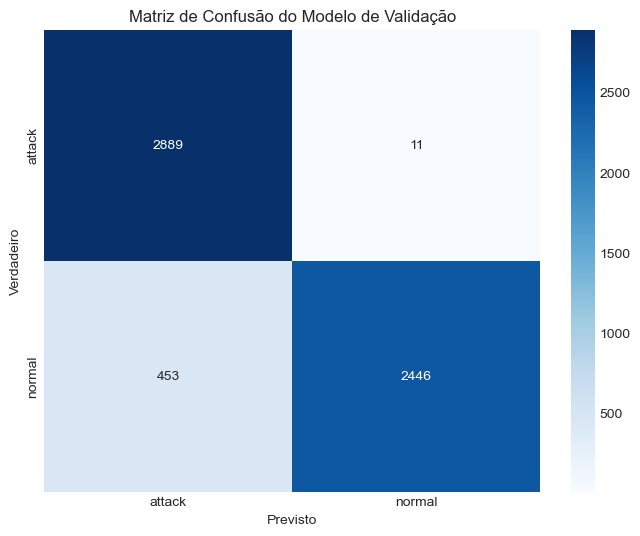

In [6]:

if not df_train.empty and best_model_instance:
    print(f"--- Métricas de Desempenho do Melhor Modelo ({best_model_name}) ---")
    
    # Usa o melhor modelo já treinado na Célula 3 para prever no conjunto de validação
    val_preds = best_model_instance.predict(X_val)
    
    # 1. Acurácia (Overall Accuracy)
    accuracy = accuracy_score(y_val, val_preds)
    print(f"Acurácia Geral (Macro): {accuracy:.4f}")

    # 2. F1-Score com Média Macro
    f1_macro = f1_score(y_val, val_preds, average='macro')
    print(f"F1-Score (Macro): {f1_macro:.4f}")
    
    # 3. Matriz de Confusão
    cm = confusion_matrix(y_val, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão do Modelo de Validação')
    plt.show()